In [5]:
"""
Run regressions that strip predictable components of consumption and income
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
sys.path.append('/home/mitch/util/python/')
from stargazer.stargazer import Stargazer

import mpl

import utils
import os

import statsmodels.stats.weightstats as ws

plotdir = '/home/mitch/school/data/mexico_enigh/fig/'

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed/'

save = False


In [6]:
os.chdir(processed)
df = pd.read_csv('data.csv')

df = df.query('Y >= 1994').query('Y <= 1996')
df['post'] = df['Y'] == 1996
df

/tmp/ipykernel_2154576/1874065039.py:2: DtypeWarning: Columns (70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,terceros,pago_tar,deudas,monedas,casas,balance,otra_ero,clase_hog,nom_emp,post
0,19940110010,1001,169,1,6480.0,0.0,920.31,1680.0,7400.31,5062.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,19940110030,1001,169,1,2760.0,0.0,593.54,0.0,3353.54,2002.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,19940110040,1001,169,1,6600.0,0.0,1533.85,0.0,8133.85,4925.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,19940110060,1001,153,1,7560.0,200.0,1305.79,0.0,8865.79,4109.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,19940110070,1001,153,1,13000.0,500.0,3185.04,0.0,16185.04,11161.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20541,19963399020,15033,1351,1,4800.0,0.0,306.67,0.0,5106.67,4182.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20542,19963399030,15033,1351,1,2950.0,0.0,1257.35,0.0,4207.35,2359.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20543,19963399040,15033,1351,1,2650.0,200.0,920.01,0.0,3570.01,2046.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
20544,19963399060,15109,1077,2,5280.0,500.0,3610.95,0.0,8890.95,5860.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [7]:
income = pd.read_csv('income.csv')
income

In [10]:
df = df.merge(income, on=['hhid'], how='inner')

In [11]:
cpidir = '/home/mitch/Dropbox/data/cpi/'
os.chdir(cpidir)
cpi = pd.read_csv('cpi_annual.csv')
cpi = cpi.rename(columns = {'time':'Y', 'PCPI_IX':'cpi'})
cpi = cpi.query('country == "MX"')
cpi = cpi.drop(columns=['Unnamed: 0', 'country'])
df = df.merge(cpi, on='Y', how='inner')

In [12]:
# don't include: other income
# transfers
# rental income

# do include:
# salary income
# business income

is1992 = df['Y'] == 1992

#income = ['salary_income', 'business_income', 'transfers_income']
income = ['income_real']
df['income'] = df[income].sum(axis=1)
#df['income'] = df['income'] / df['cpi']
df['income'] = df['income'] / df['hh_size']
df.loc[is1992, 'income'] = df.loc[is1992, 'income'] / 1000
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
#consumption = ['consumption_food', 'consumption_clothing', 'consumption_personal', 'consumption_education']
df['consumption'] = df[consumption].sum(axis=1)
df['consumption'] = df['consumption'] / df['cpi']
df['consumption'] = df['consumption'] / df['hh_size']
df.loc[is1992, 'consumption'] = df.loc[is1992, 'consumption'] / 1000
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
df = df.query('relationship_to_hhm == 1')
df = df.query('income > 0')
df = df.query('consumption > 0')
df = df.query('age >= 25')
df = df.query('age <= 60')
df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

In [14]:
consumption_to_income = ws.DescrStatsW(df['consumption'] / df['income'], weights=df['weight'])
consumption_to_income_005 = consumption_to_income.quantile(0.005)
consumption_to_income_995 = consumption_to_income.quantile(0.995)
df = df[df['consumption'] / df['income'] > consumption_to_income_005.values[0]]
df = df[df['consumption'] / df['income'] < consumption_to_income_995.values[0]]

In [15]:
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = utils.get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
    

In [16]:
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')
df

,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,nom_emp,post,income_real,income_nominal,cpi,income,log_income,consumption,log_consumption,decile
0,19940110010,1001,169,1,6480.0,0.0,920.31,1680.0,7400.31,5062.41,...,NaN,False,494.027509,9600.0,19.551304,54.891945,4.005367,12.826595,2.551521,3
1,19940110030,1001,169,1,2760.0,0.0,593.54,0.0,3353.54,2002.79,...,NaN,False,148.208253,2880.0,19.551304,49.402751,3.900006,24.818805,3.211602,2
2,19940110040,1001,169,1,6600.0,0.0,1533.85,0.0,8133.85,4925.66,...,NaN,False,314.942537,6120.0,19.551304,52.490423,3.960631,23.500223,3.157010,3
3,19940110060,1001,153,1,7560.0,200.0,1305.79,0.0,8865.79,4109.89,...,NaN,False,506.378197,9840.0,19.551304,101.275639,4.617846,22.068809,3.094165,5
4,19940110070,1001,153,1,13000.0,500.0,3185.04,0.0,16185.04,11161.73,...,NaN,False,1131.543971,22000.0,19.551304,188.590662,5.239579,58.902636,4.075886,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12944,19963399020,15033,1351,1,4800.0,0.0,306.67,0.0,5106.67,4182.13,...,NaN,True,265.909424,9600.0,35.467989,66.477356,4.196861,17.261058,2.848453,5
12945,19963399030,15033,1351,1,2950.0,0.0,1257.35,0.0,4207.35,2359.12,...,NaN,True,163.835230,5900.0,35.467989,40.958807,3.712567,9.475728,2.248734,3
12946,19963399040,15033,1351,1,2650.0,200.0,920.01,0.0,3570.01,2046.06,...,NaN,True,157.559176,5700.0,35.467989,22.508454,3.113891,5.710783,1.742356,1
12947,19963399060,15109,1077,2,5280.0,500.0,3610.95,0.0,8890.95,5860.77,...,NaN,True,119.808861,4360.0,35.467989,39.936287,3.687285,38.139556,3.641252,3


In [17]:
params = ['post[T.True]:C(decile)[' + str(x) + ']' for x in np.arange(1, 11) ]

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
fam = sm.families.Gaussian(identity())

In [19]:
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = ' post:C(education) + post:C(sex)'

income_reg = 'log_income ~ ' + Z + '+' + D
#income_reg = 'log_income ~ ' + Z 
#income_model = smf.wls(income_reg, df, weights=df['weight']).fit()
income_model = smf.glm(income_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_income_resid'] = income_model.resid

In [20]:
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = 'post:C(education) + post:C(sex)'

consumption_reg = 'log_consumption ~ ' + Z + '+' + D
#income_reg = 'log_consumption ~ ' + Z 
#consumption_model = smf.wls(consumption_reg, df, weights=df['weight']).fit()
consumption_model = smf.glm(consumption_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_consumption_resid'] = consumption_model.resid

In [21]:
consumption_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        log_consumption   No. Observations:                12949
Model:                            GLM   Df Residuals:                 22992755
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                         0.23541
Method:                          IRLS   Log-Likelihood:            -1.5997e+07
Date:                Wed, 29 Nov 2023   Deviance:                   5.4128e+06
Time:                        16:24:40   Pearson chi2:                 5.41e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               3.0128      0.002   1463.886      0.000       3.009       3.017
C(sex)[T.2]                             0.1194      0.000    278.559      0.000       0.119       0.120
C(education)[T.low]                    -0.0490      0.001    -96.244      0.000      -0.050      -0.048
C(education)[T.medium]                 -0.0137      0.000    -28.278      0.000      -0.015      -0.013
C(location_size)[T.2]                  -0.0166      0.000    -60.380      0.000      -0.017      -0.016
C(location_size)[T.3]                  -0.0795      0.000   -270.467      0.000      -0.080      -0.079
C(decile)[T.2]                          0.1974      0.001    300.542      0.000       0.196       0.199
C(decile)[T.3]                          0.3498      0.001    531.858      0.000       0.348       0.351
C(decile)[T.4]                          0.5808      0.001    873.164      0.000       0.580       0.582
C(decile)[T.5]                          0.6957      0.001   1041.530      0.000       0.694       0.697
C(decile)[T.6]                          0.8407      0.001   1246.516      0.000       0.839       0.842
C(decile)[T.7]                          0.9789      0.001   1445.134      0.000       0.978       0.980
C(decile)[T.8]                          1.2380      0.001   1798.930      0.000       1.237       1.239
C(decile)[T.9]                          1.5041      0.001   2130.555      0.000       1.503       1.506
C(decile)[T.10]                         2.0917      0.001   2789.655      0.000       2.090       2.093
post[T.True]:C(decile)[1]              -0.3442      0.001   -370.163      0.000      -0.346      -0.342
post[T.True]:C(decile)[2]              -0.1842      0.001   -203.256      0.000      -0.186      -0.182
post[T.True]:C(decile)[3]              -0.2104      0.001   -232.552      0.000      -0.212      -0.209
post[T.True]:C(decile)[4]              -0.2564      0.001   -286.378      0.000      -0.258      -0.255
post[T.True]:C(decile)[5]              -0.2432      0.001   -277.002      0.000      -0.245      -0.241
post[T.True]:C(decile)[6]              -0.2430      0.001   -284.491      0.000      -0.245      -0.241
post[T.True]:C(decile)[7]              -0.2181      0.001   -261.514      0.000      -0.220      -0.216
post[T.True]:C(decile)[8]              -0.2426      0.001   -303.368      0.000      -0.244      -0.241
post[T.True]:C(decile)[9]              -0.2897      0.001   -384.298      0.000      -0.291      -0.288
post[T.True]:C(decile)[10]             -0.3448      0.001   -506.768      0.000      -0.346      -0.343
post[T.True]:C(education)[T.low]        0.0382      0.001     54.636      0.000       0.037       0.040
post[T.True]:C(education)[T.medium]     0.0259      0.001     38.92

In [22]:
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                12949
Model:                            GLM   Df Residuals:                 22992755
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                        0.056174
Method:                          IRLS   Log-Likelihood:             4.7627e+05
Date:                Wed, 29 Nov 2023   Deviance:                   1.2916e+06
Time:                        16:24:40   Pearson chi2:                 1.29e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               3.3154      0.001   3297.795      0.000       3.313       3.317
C(sex)[T.2]                            -0.0280      0.000   -133.512      0.000      -0.028      -0.028
C(education)[T.low]                    -0.0422      0.000   -169.602      0.000      -0.043      -0.042
C(education)[T.medium]                 -0.0178      0.000    -75.627      0.000      -0.018      -0.017
C(location_size)[T.2]                  -0.0062      0.000    -46.527      0.000      -0.007      -0.006
C(location_size)[T.3]                  -0.0421      0.000   -293.125      0.000      -0.042      -0.042
C(decile)[T.2]                          0.5738      0.000   1788.596      0.000       0.573       0.574
C(decile)[T.3]                          0.8937      0.000   2781.981      0.000       0.893       0.894
C(decile)[T.4]                          1.1350      0.000   3493.042      0.000       1.134       1.136
C(decile)[T.5]                          1.3685      0.000   4193.975      0.000       1.368       1.369
C(decile)[T.6]                          1.6138      0.000   4898.346      0.000       1.613       1.614
C(decile)[T.7]                          1.8847      0.000   5695.756      0.000       1.884       1.885
C(decile)[T.8]                          2.2084      0.000   6569.126      0.000       2.208       2.209
C(decile)[T.9]                          2.6478      0.000   7677.799      0.000       2.647       2.648
C(decile)[T.10]                         3.5108      0.000   9585.442      0.000       3.510       3.512
post[T.True]:C(decile)[1]              -0.3866      0.000   -851.220      0.000      -0.387      -0.386
post[T.True]:C(decile)[2]              -0.2901      0.000   -655.443      0.000      -0.291      -0.289
post[T.True]:C(decile)[3]              -0.2760      0.000   -624.656      0.000      -0.277      -0.275
post[T.True]:C(decile)[4]              -0.2735      0.000   -625.445      0.000      -0.274      -0.273
post[T.True]:C(decile)[5]              -0.2797      0.000   -652.244      0.000      -0.281      -0.279
post[T.True]:C(decile)[6]              -0.2959      0.000   -708.961      0.000      -0.297      -0.295
post[T.True]:C(decile)[7]              -0.2979      0.000   -731.161      0.000      -0.299      -0.297
post[T.True]:C(decile)[8]              -0.3171      0.000   -811.775      0.000      -0.318      -0.316
post[T.True]:C(decile)[9]              -0.3277      0.000   -889.793      0.000      -0.328      -0.327
post[T.True]:C(decile)[10]             -0.3800      0.000  -1143.503      0.000      -0.381      -0.379
post[T.True]:C(education)[T.low]        0.0013      0.000      3.901      0.000       0.001       0.002
post[T.True]:C(education)[T.medium]    -0.0169      0.000    -51.95

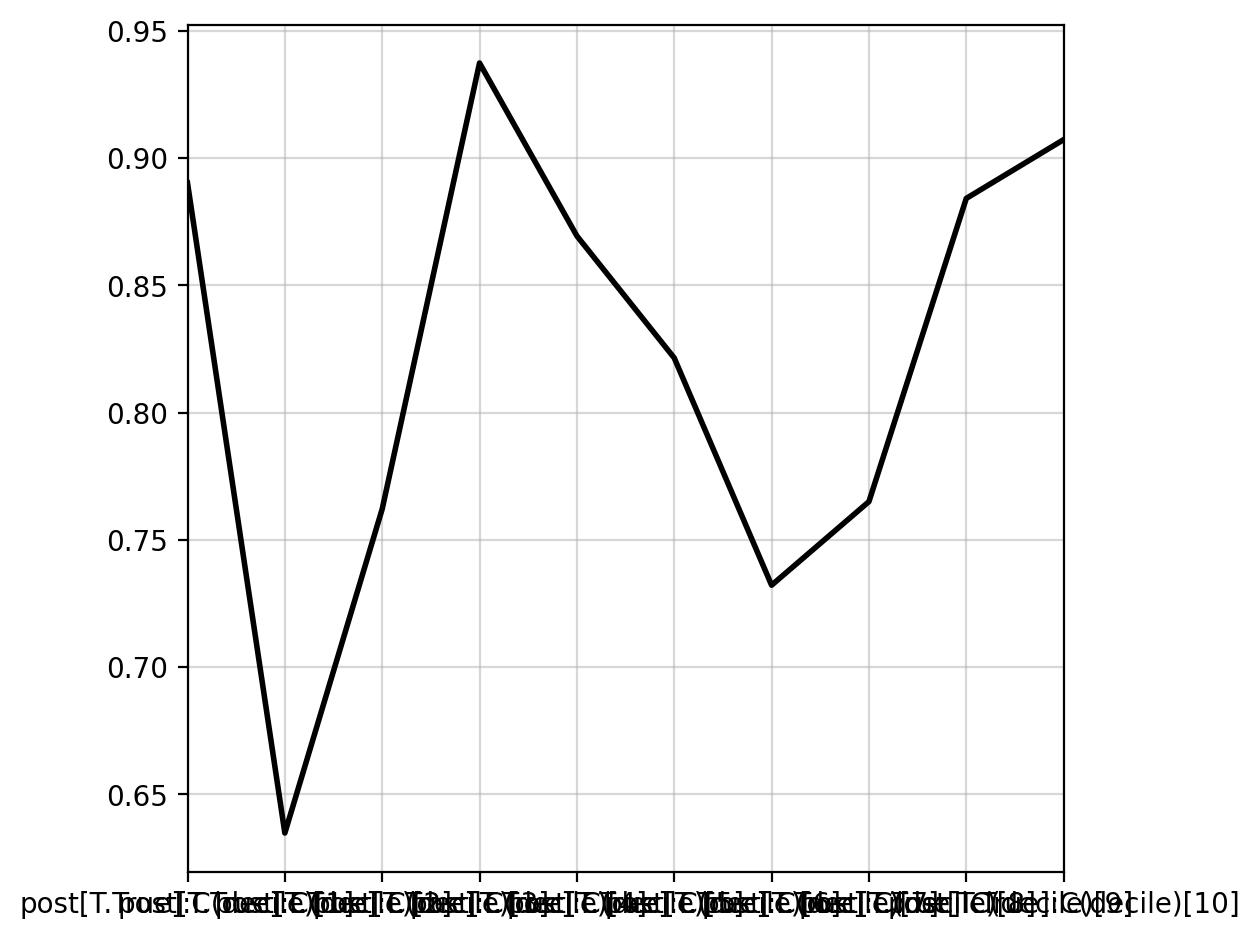

In [24]:
plt.clf()
plt.plot(consumption_model.params[params] / income_model.params[params])
plt.show()

In [25]:
nboot = 1000
dconsumption = np.zeros((nboot, 10))
dincome = np.zeros((nboot, 10))
for boot in np.arange(nboot):
    # matters alot: double vs single resampling of the data
    # something tells me single sampling is correct
    # this is correct because: are matching the samples of the original data 
    # so should be all set 
    data_boot = df.copy().sample(len(data), weights=df['weight'], replace=True, axis=0)
    #data_boot = df.copy().sample(len(data), replace=True, axis=0)

    #consumption_model = smf.wls(consumption_reg, data_boot, weights=data_boot['weight']).fit()
    #consumption_model = smf.glm(consumption_reg, data_boot, freq_weights=data_boot['weight'], missing='drop', family=fam).fit()
    consumption_model = smf.glm(consumption_reg, data_boot, missing='drop', family=fam).fit()
    dconsumption[boot, :] = consumption_model.params[params]

    #income_model = smf.wls(income_reg, data_boot, weights=data_boot['weight']).fit()
    #income_model = smf.glm(income_reg, data_boot, freq_weights=data_boot['weight'],  missing='drop', family=fam).fit()
    income_model = smf.glm(income_reg, data_boot,  missing='drop', family=fam).fit()
    dincome[boot, :] = income_model.params[params]


In [26]:
dincome

array([[-0.46363581, -0.33235146, -0.31448424, ..., -0.3566106 ,
        -0.35097737, -0.44270089],
       [-0.3554799 , -0.28519479, -0.26114061, ..., -0.29192988,
        -0.3015673 , -0.38104894],
       [-0.40674343, -0.26648577, -0.25052184, ..., -0.30779167,
        -0.32410834, -0.29124629],
       ...,
       [-0.39254425, -0.31339535, -0.29481454, ..., -0.32270807,
        -0.32941387, -0.41436472],
       [-0.38982086, -0.29997125, -0.28973618, ..., -0.32784828,
        -0.35131501, -0.36283871],
       [-0.3224592 , -0.24779447, -0.23969165, ..., -0.27986241,
        -0.30602398, -0.37592908]])

In [27]:
deciles = np.arange(1, 11)

dconsumption_c10 = [np.quantile(dconsumption[:, ii], 0.10) for ii in np.arange(10)]
dconsumption_c90 = [np.quantile(dconsumption[:, ii], 0.90) for ii in np.arange(10)]
dconsumption_mean = [np.mean(dconsumption[:, ii]) for ii in np.arange(10)]

dincome_c10 = [np.quantile(dincome[:, ii], 0.10) for ii in np.arange(10)]
dincome_c90 = [np.quantile(dincome[:, ii], 0.90) for ii in np.arange(10)]
dincome_mean = [np.mean(dincome[:, ii]) for ii in np.arange(10)]


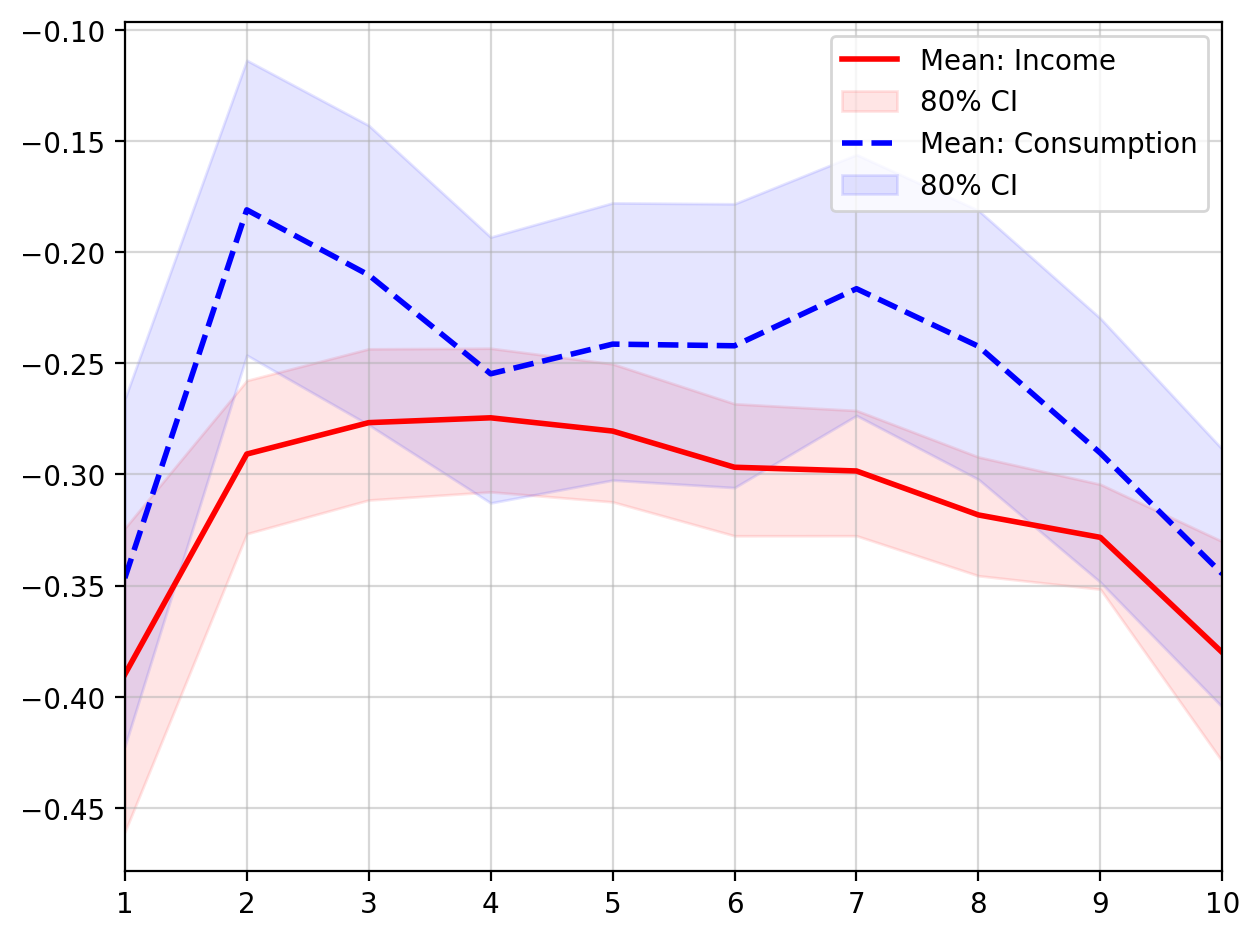

In [28]:
plt.clf()

plt.plot(deciles, dincome_mean, color='red', label='Mean: Income')
plt.fill_between(deciles, dincome_c10, dincome_c90, color='red', alpha=0.10, label='80% CI')

plt.plot(deciles, dconsumption_mean, color='blue', label='Mean: Consumption')
plt.fill_between(deciles, dconsumption_c10, dconsumption_c90, color='blue', alpha=0.10, label='80% CI')

plt.legend()


#plt.gca().set_ylim(top=0)
plt.show()
#plt.plot(dconsumption_c10, label='lower')
#plt.plot(dconsumption_c90, label='upper')

<Figure size 1280x960 with 0 Axes>

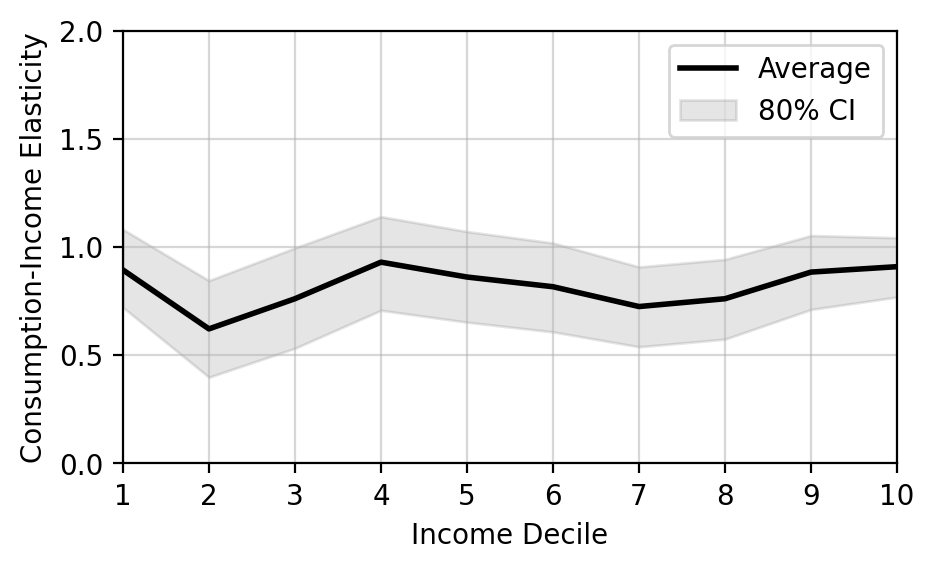

In [29]:
delasticity = dconsumption / dincome

plt.clf()
plt.figure(figsize = mpl.set_size())

delasticity_c10 = [np.quantile(delasticity[:, ii], 0.10) for ii in np.arange(10)]
delasticity_c90 = [np.quantile(delasticity[:, ii], 0.90) for ii in np.arange(10)]
delasticity_mean = [np.mean(delasticity[:, ii]) for ii in np.arange(10)]

plt.plot(deciles, delasticity_mean, label='Average', color='black')
plt.fill_between(deciles, delasticity_c10, delasticity_c90, color='black', alpha=0.10, label='80% CI')
plt.xlabel('Income Decile')
plt.ylim(0, 2.0)
plt.yticks(np.arange(0, 2.50, 0.50))
plt.ylabel('Consumption-Income Elasticity')

plt.legend()

if save:
    os.chdir(plotdir)
#    plt.savefig('elasticity_1994_1996_cugat_withci.png')
plt.show()
    

#plt.gca().set_ylim(top=0)